In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
from hydra.utils import instantiate
from hydra import initialize, compose
import hydra
import wandb

from data.dataManager import DataManager
from model.modelCreator import ModelCreator
from omegaconf import OmegaConf
from scripts.run import setup_model, load_model_instance

[21:42:07.312] INFO   CaloQuVAE                                         Loading configuration.


In [2]:
hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base=None, config_path="config")
config=compose(config_name="config.yaml")
wandb.init(tags = [config.data.dataset_name], project=config.wandb.project, entity=config.wandb.entity, config=OmegaConf.to_container(config, resolve=True), mode='disabled')

In [3]:

devids = ["cuda:{0}".format(x) for x in list(config.gpu_list)]
dev = torch.device(devids[0])

In [4]:
new_model = True
if new_model:
    self = setup_model(config)
    # self.model = self.model.double()  # sets all model parameters to float64
else:
    self = load_model_instance(config.config_path)
    # self.model = self.model.double()

[21:42:08.890] INFO   data.dataManager                                  Loading ATLAS dataset: AtlasReg035
[21:42:11.277] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fd17530ef00>: 101815 events, 199 batches
[21:42:11.278] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fd174235cd0>: 12728 events, 13 batches
[21:42:11.279] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fceec1c44a0>: 12726 events, 13 batches
[21:42:11.280] INFO   model.modelCreator                                ::Creating Model
[21:42:12.779] WARN   model.rbm.zephyr                                  QPU is offline. Setting a hard-coded zephyr. Check to see you're pinging the correct chip_id


/home/leozhu/CaloQuVAE


[21:42:13.213] INFO   scripts.run                                       Requesting GPUs. GPU list :[0]
[21:42:13.214] INFO   scripts.run                                       Main GPU : cuda:0
[21:42:13.402] INFO   scripts.run                                       CUDA available


cuda:0
encoder._networks.0.seq1.0.conv.weight True
encoder._networks.0.seq1.0.conv.bias True
encoder._networks.0.seq1.1.weight True
encoder._networks.0.seq1.1.bias True
encoder._networks.0.seq1.2.weight True
encoder._networks.0.seq1.3.conv.weight True
encoder._networks.0.seq1.3.conv.bias True
encoder._networks.0.seq1.4.weight True
encoder._networks.0.seq1.4.bias True
encoder._networks.0.seq1.5.weight True
encoder._networks.0.seq2.0.conv.weight True
encoder._networks.0.seq2.0.conv.bias True
encoder._networks.0.seq2.1.weight True
encoder._networks.0.seq2.1.bias True
encoder._networks.0.seq2.2.weight True
encoder._networks.0.seq2.3.conv.weight True
encoder._networks.0.seq2.3.conv.bias True
encoder._networks.0.seq2.4.weight True
encoder._networks.1.seq1.0.conv.weight True
encoder._networks.1.seq1.0.conv.bias True
encoder._networks.1.seq1.1.weight True
encoder._networks.1.seq1.1.bias True
encoder._networks.1.seq1.2.weight True
encoder._networks.1.seq1.3.conv.weight True
encoder._networks.1.

In [5]:
self.evaluate_vae(self.data_mgr.val_loader, epoch=0)

[21:42:51.860] INFO   engine.engine                                     Epoch: 0 - Average Val Loss: 48346.8918


(<Figure size 1500x1500 with 4 Axes>,
 <Figure size 1600x1000 with 15 Axes>,
 <Figure size 1600x1000 with 15 Axes>,
 <Figure size 1600x1000 with 15 Axes>,
 <Figure size 1600x1000 with 15 Axes>,
 <Figure size 1500x600 with 8 Axes>,
 <Figure size 1500x600 with 8 Axes>,
 <Figure size 1500x600 with 8 Axes>,
 <Figure size 1500x600 with 8 Axes>)

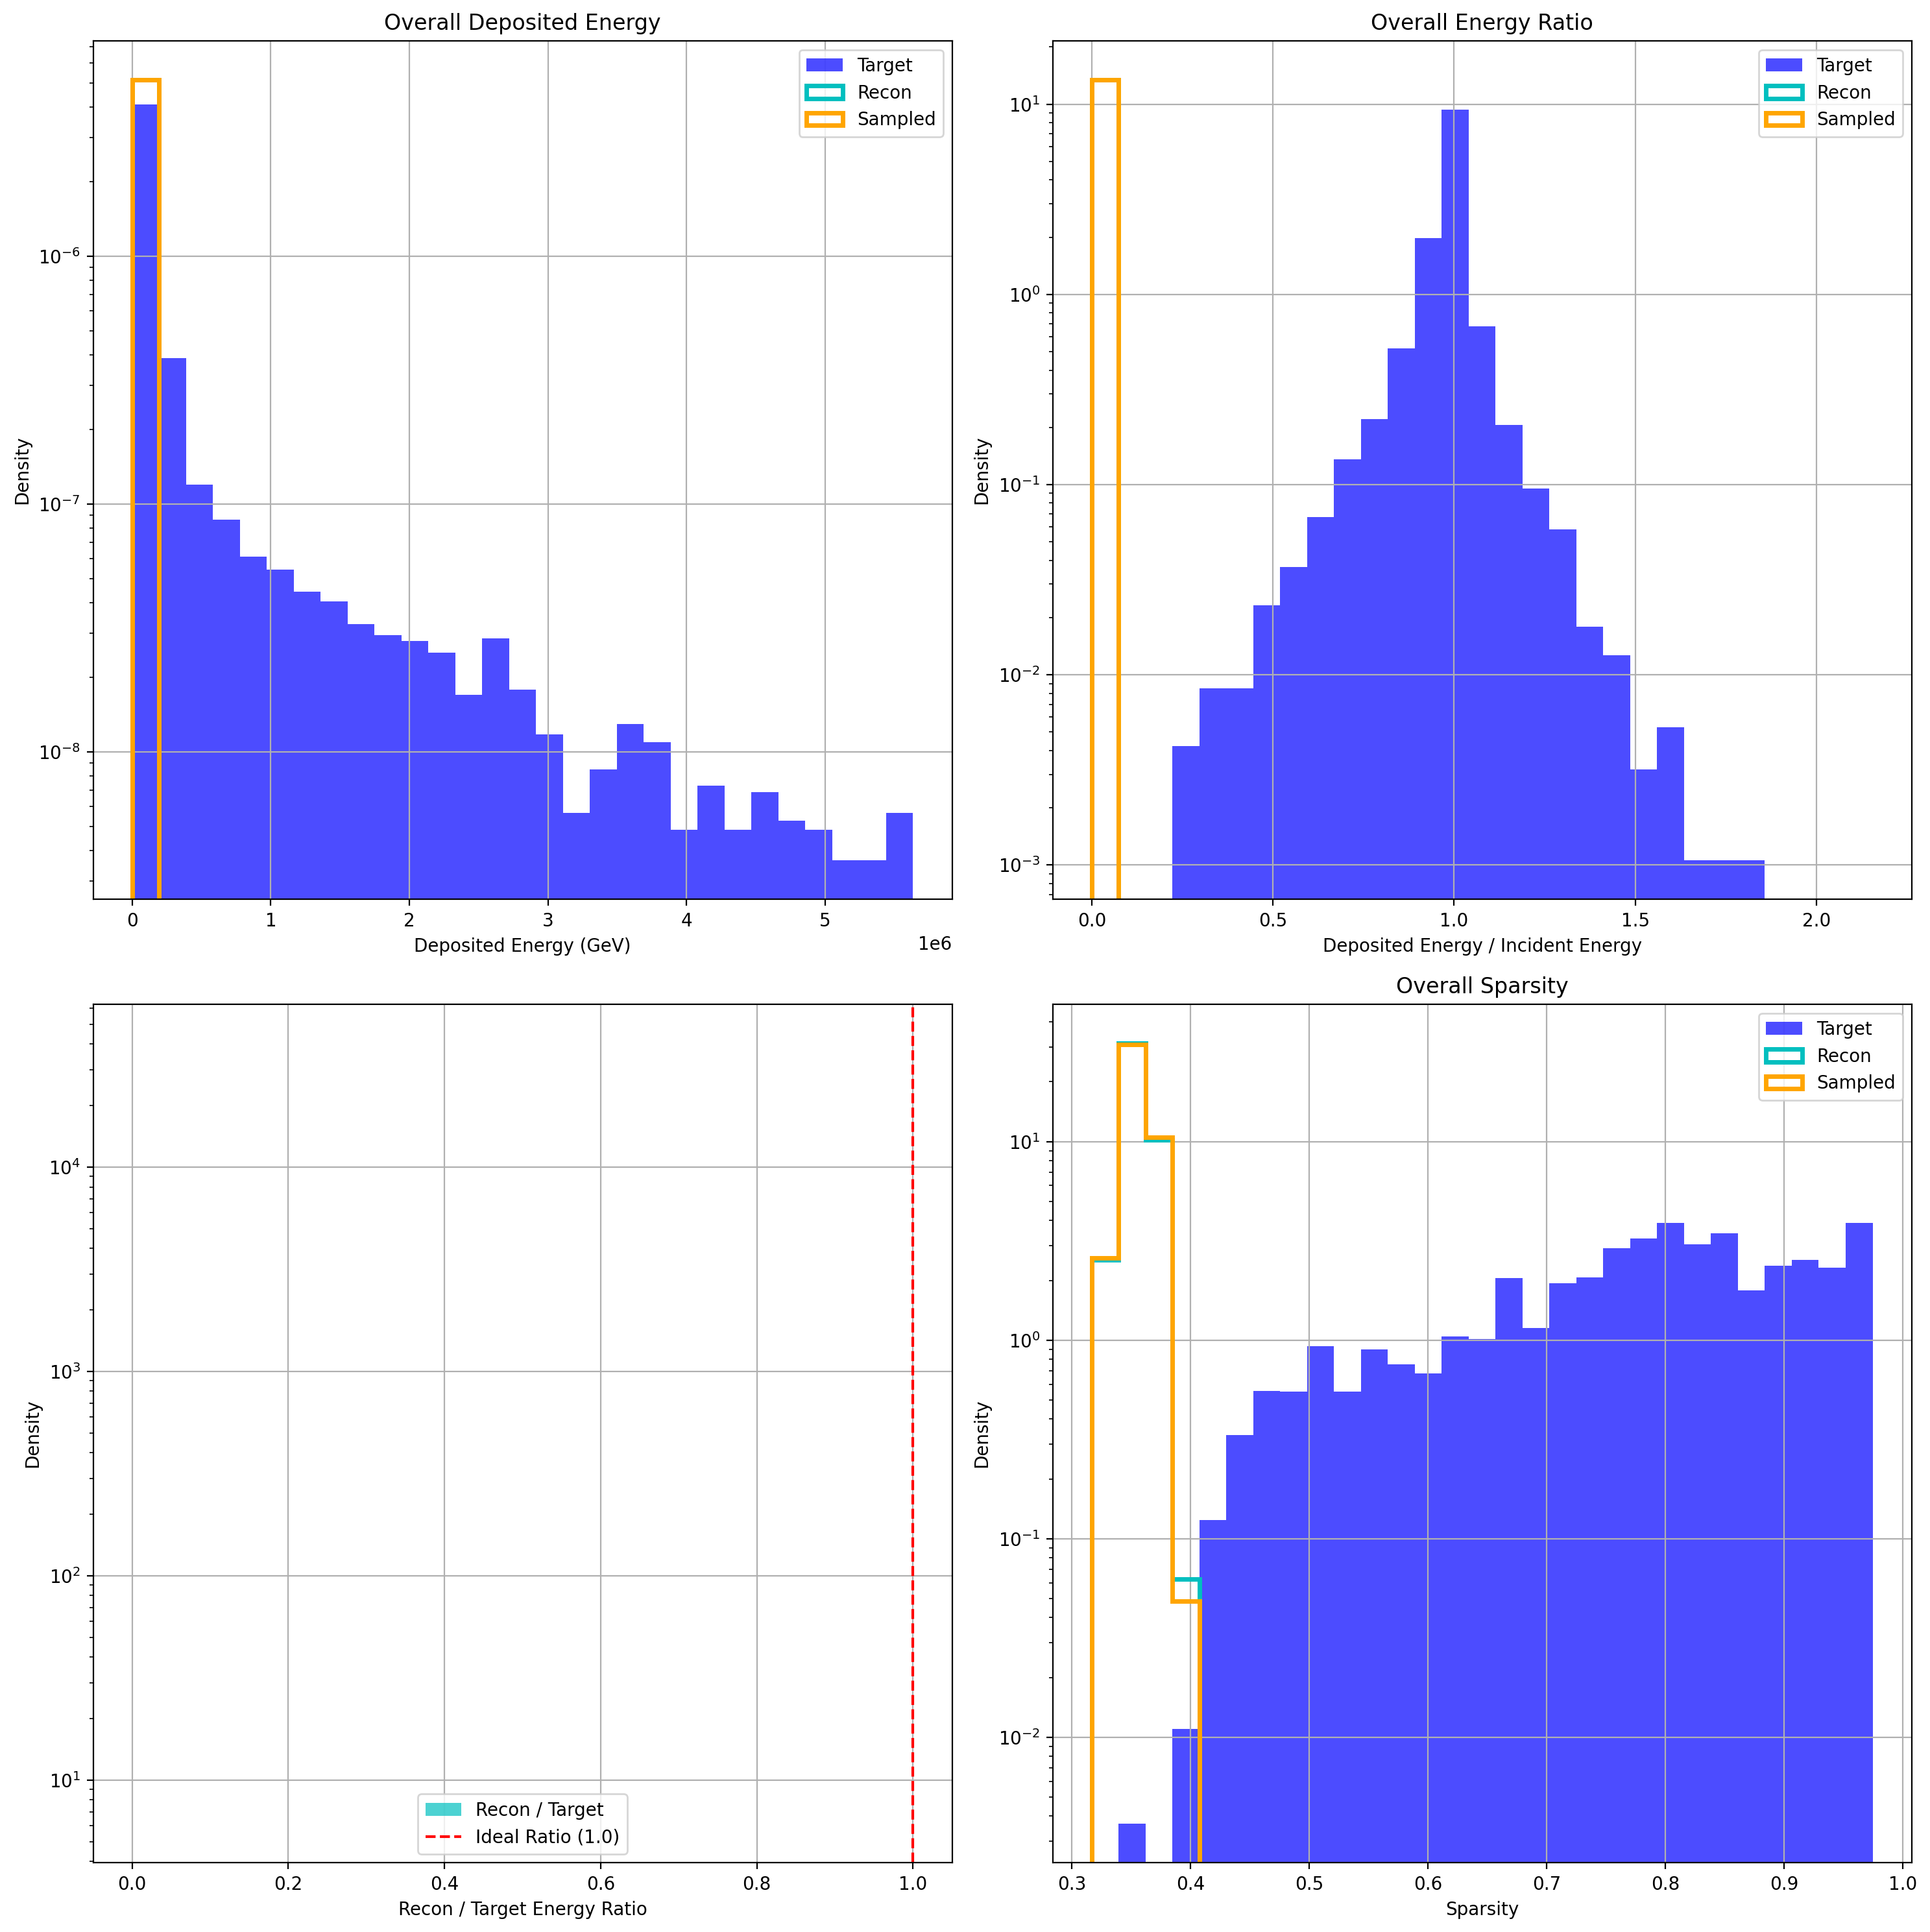

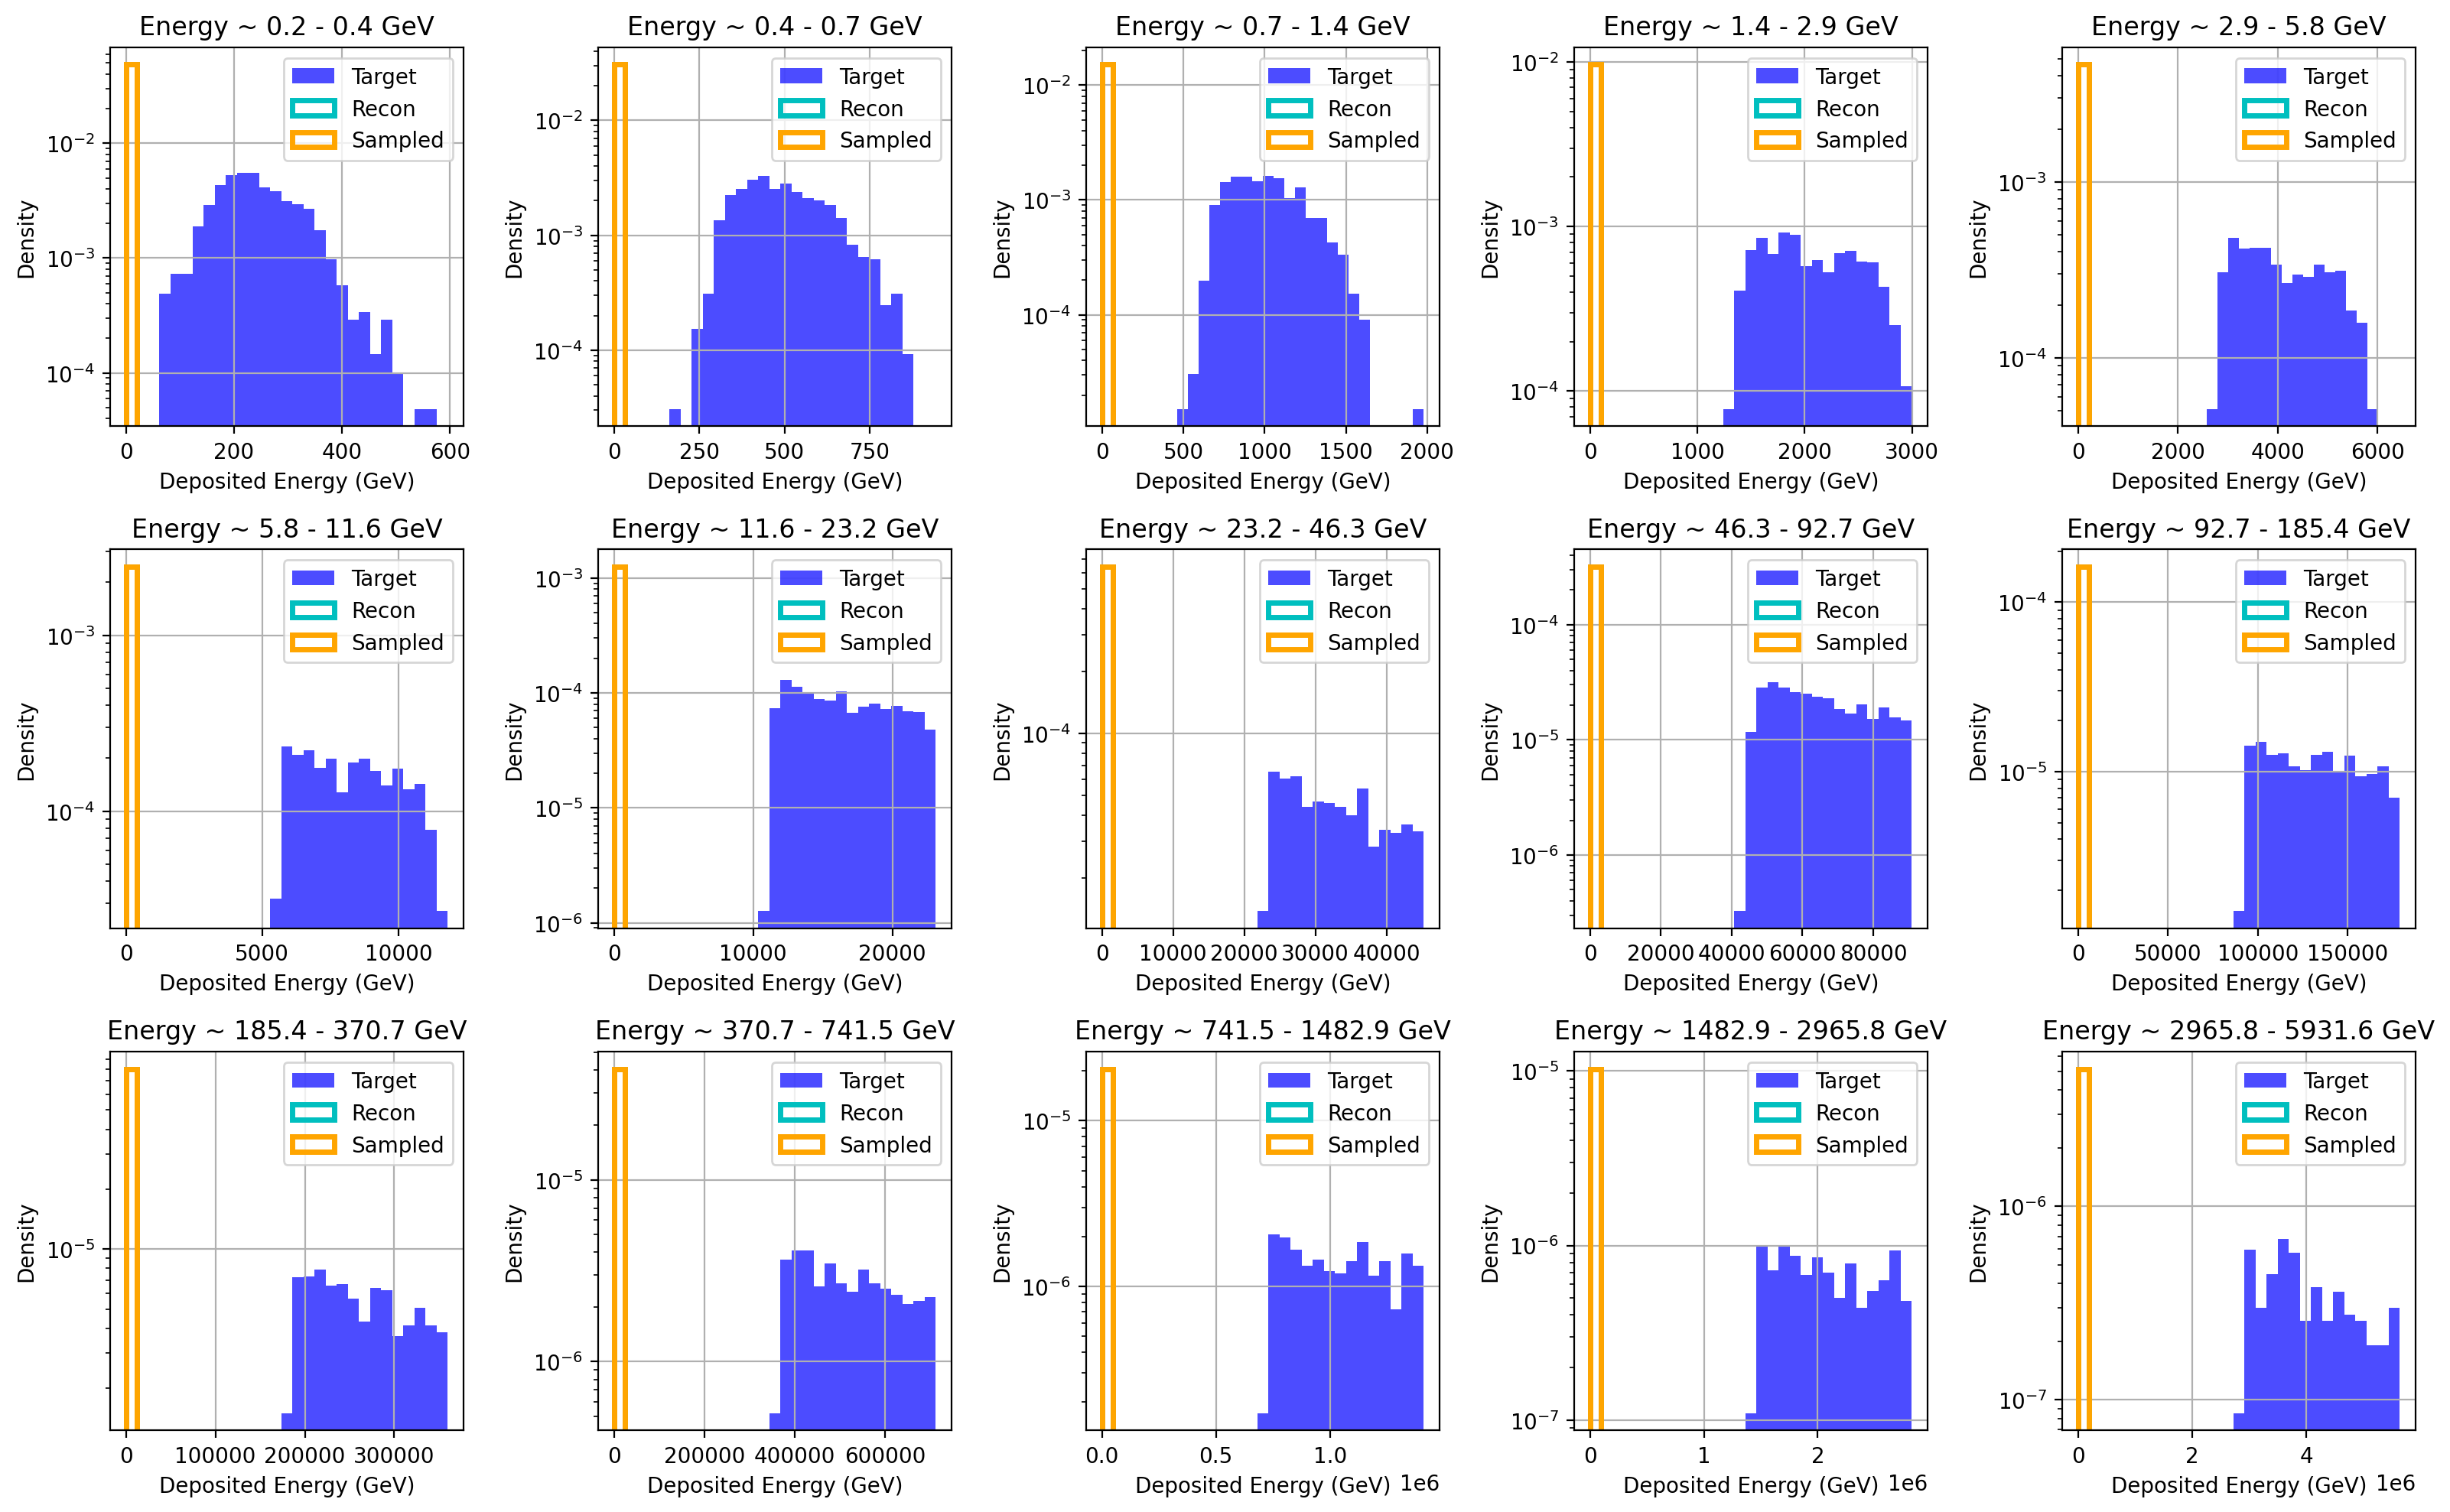

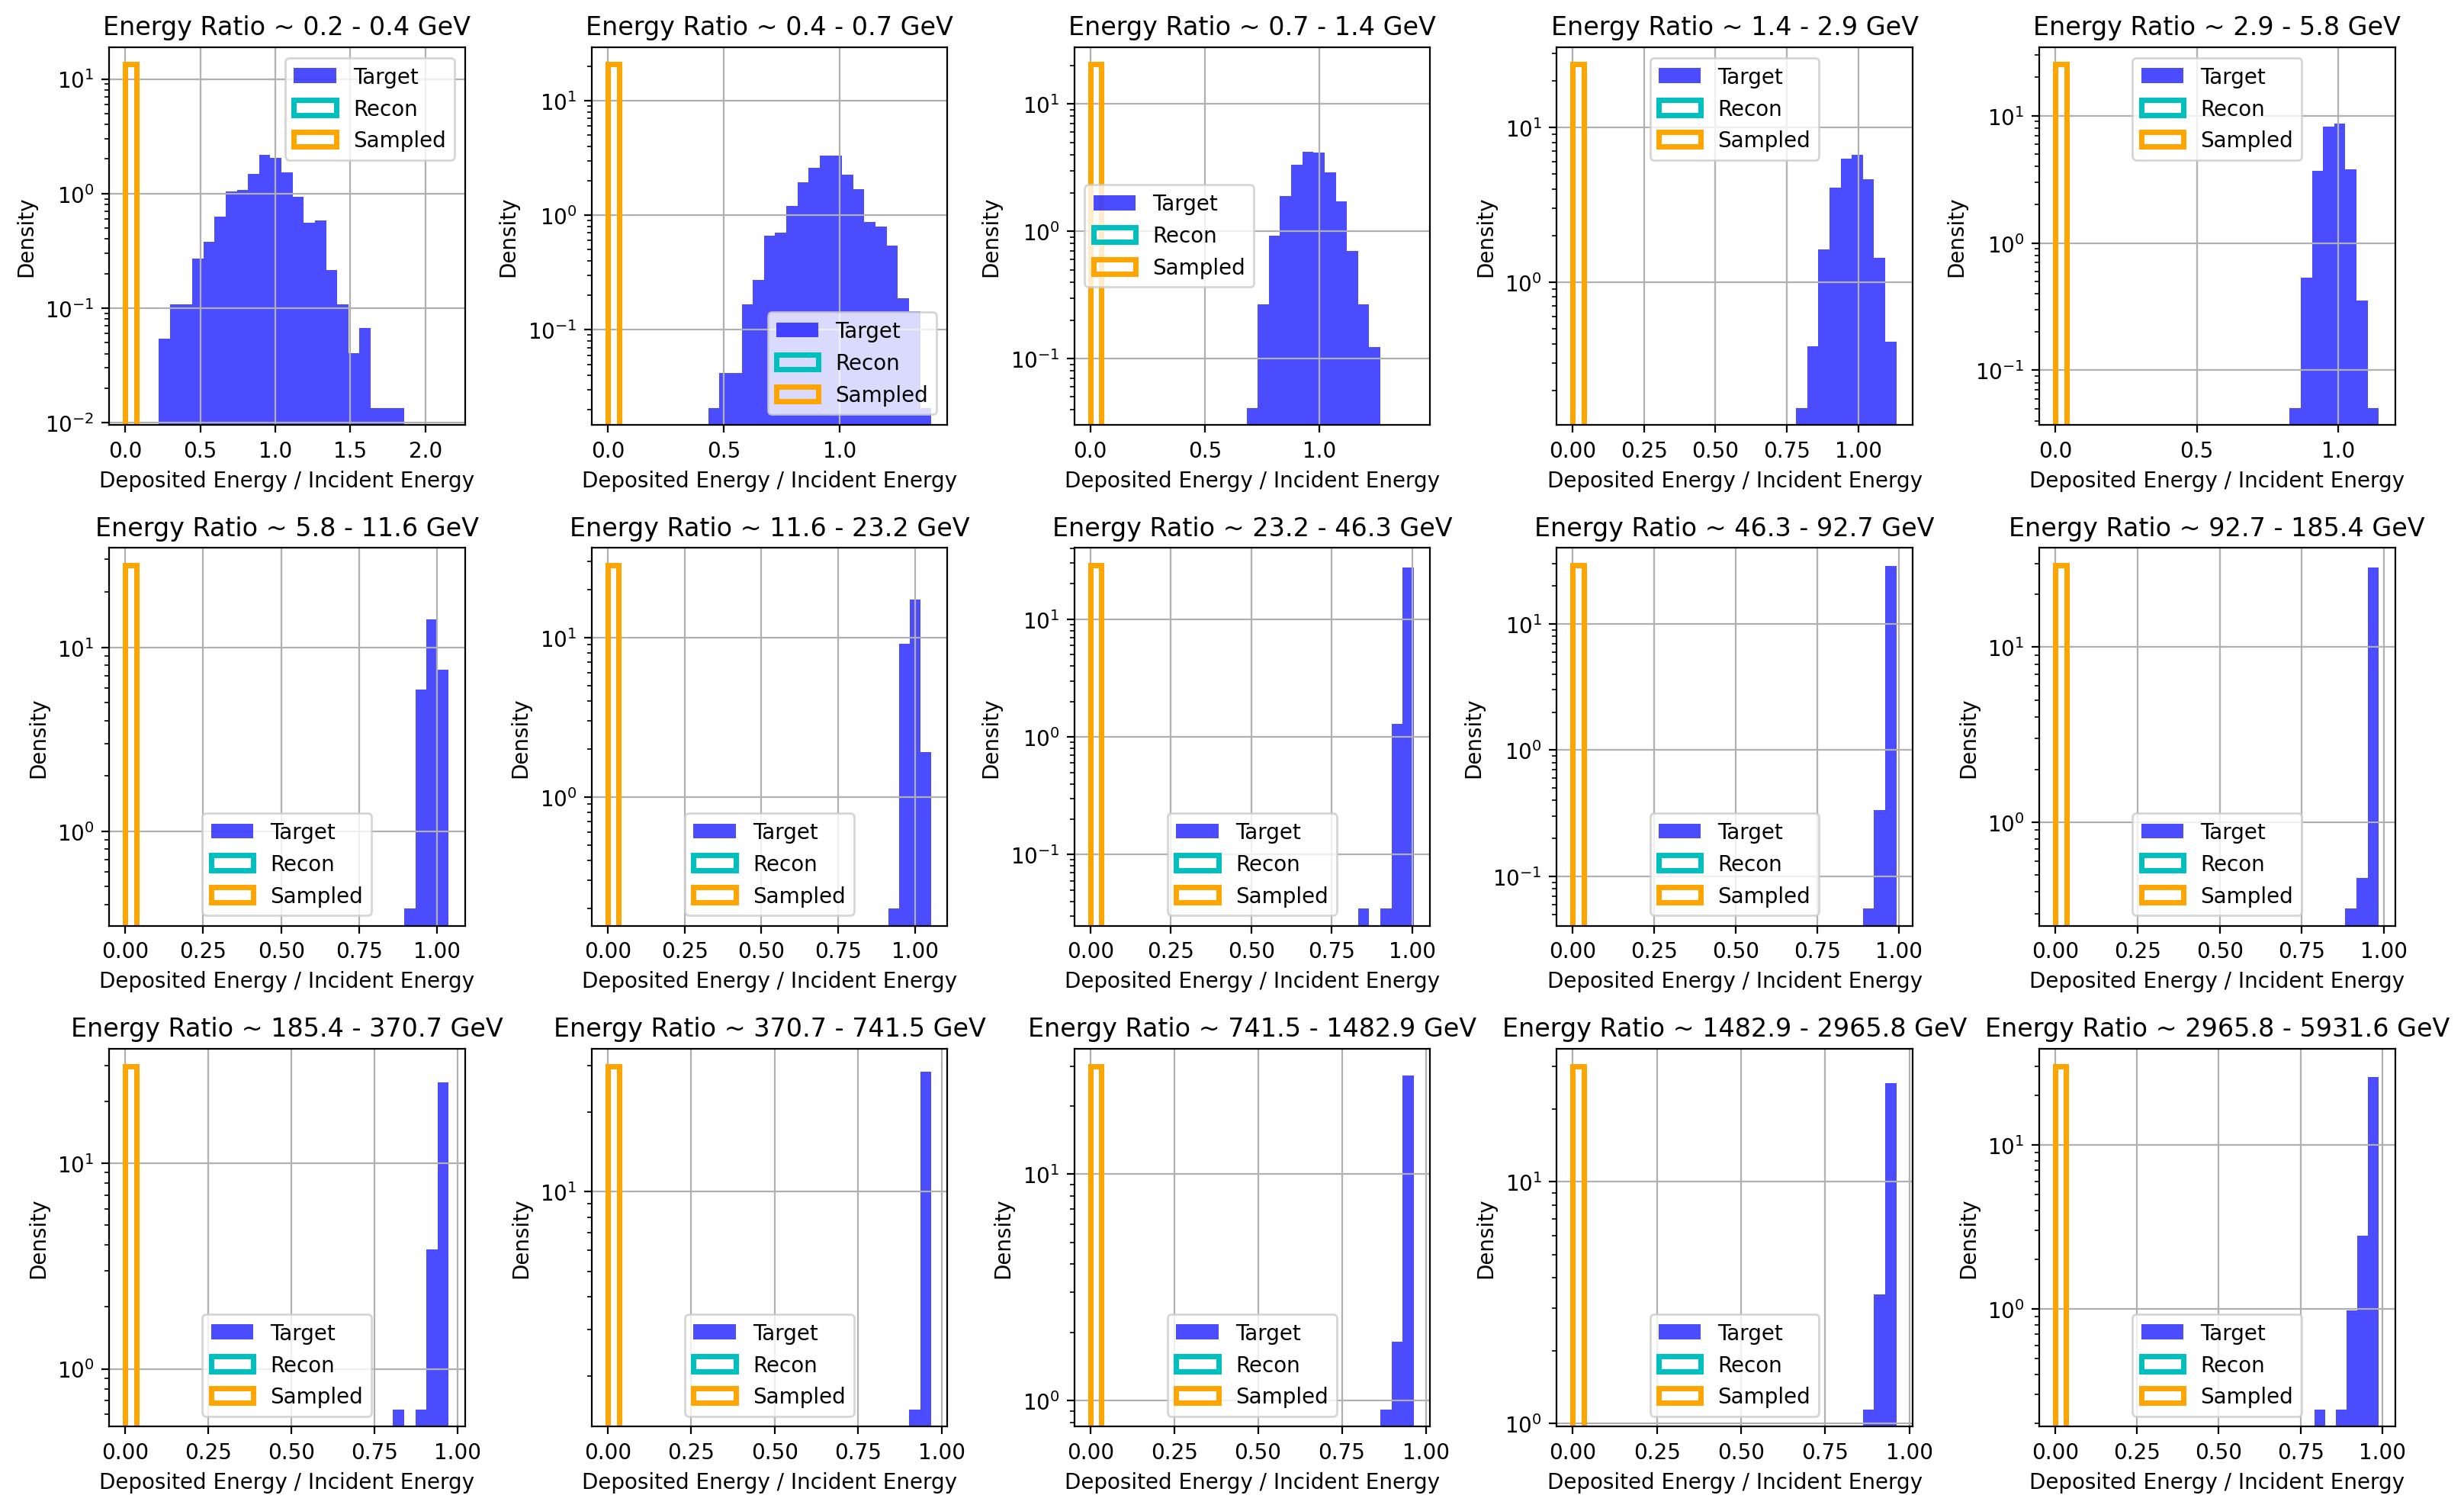

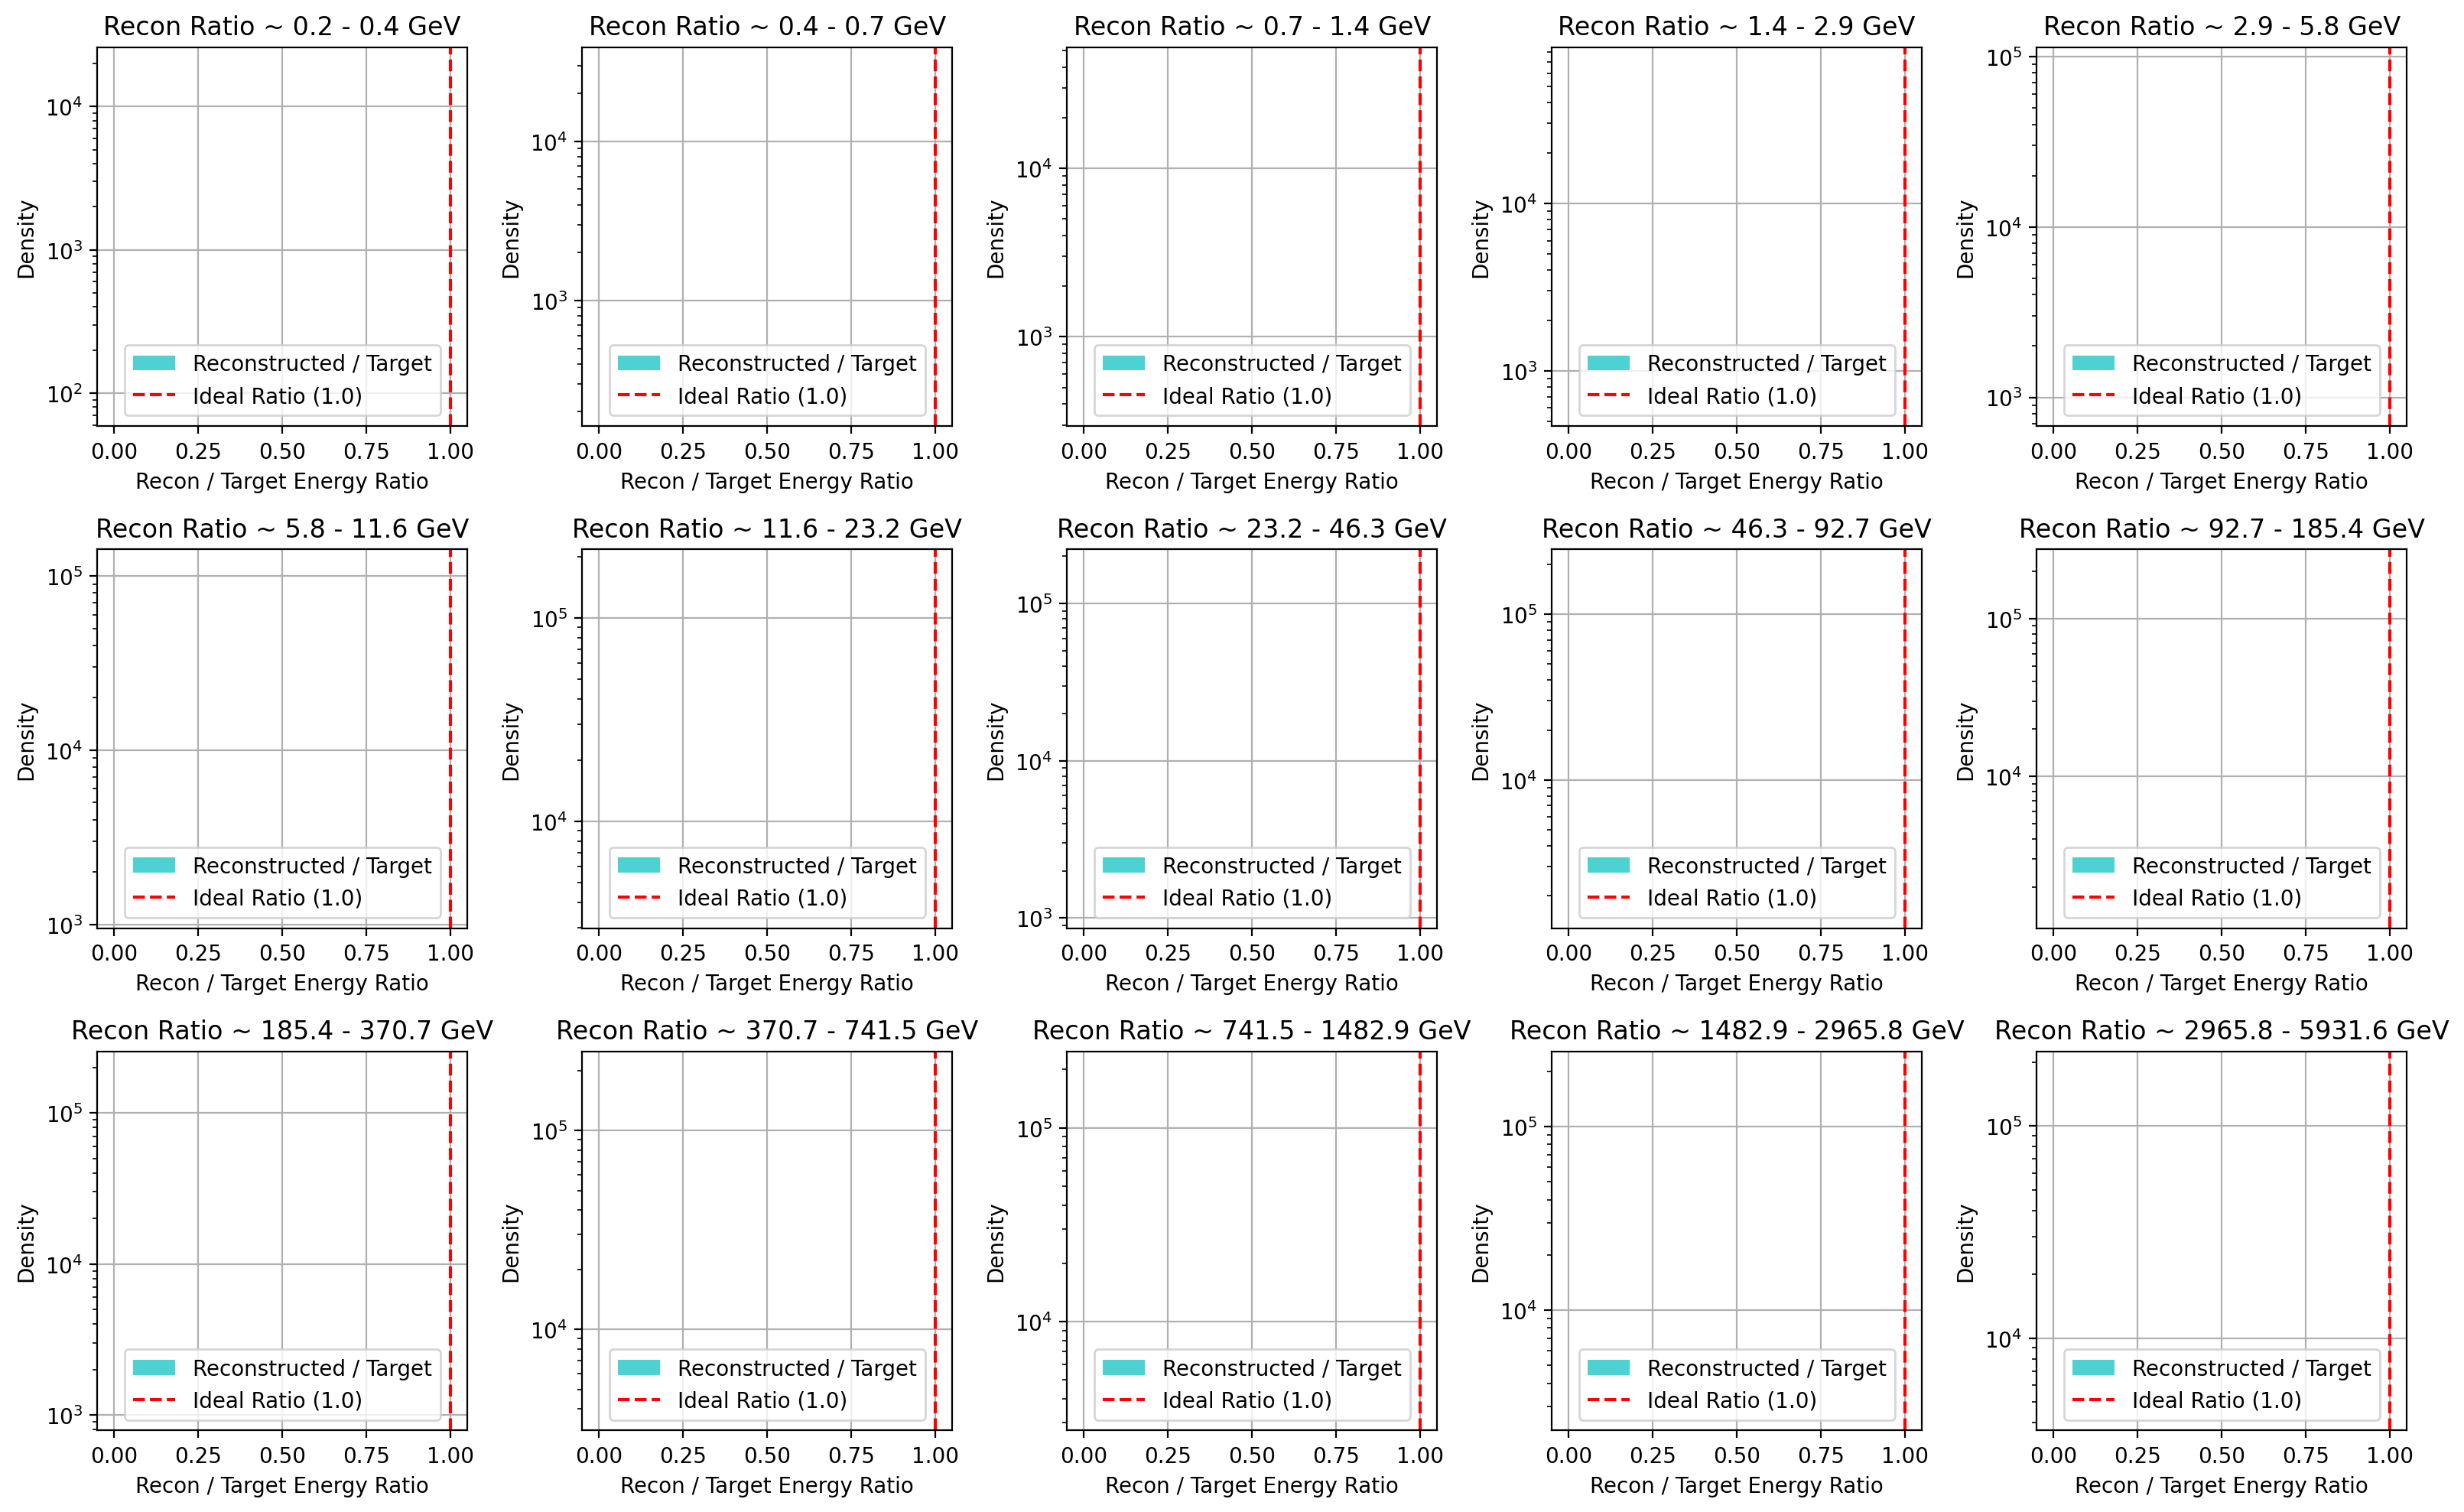

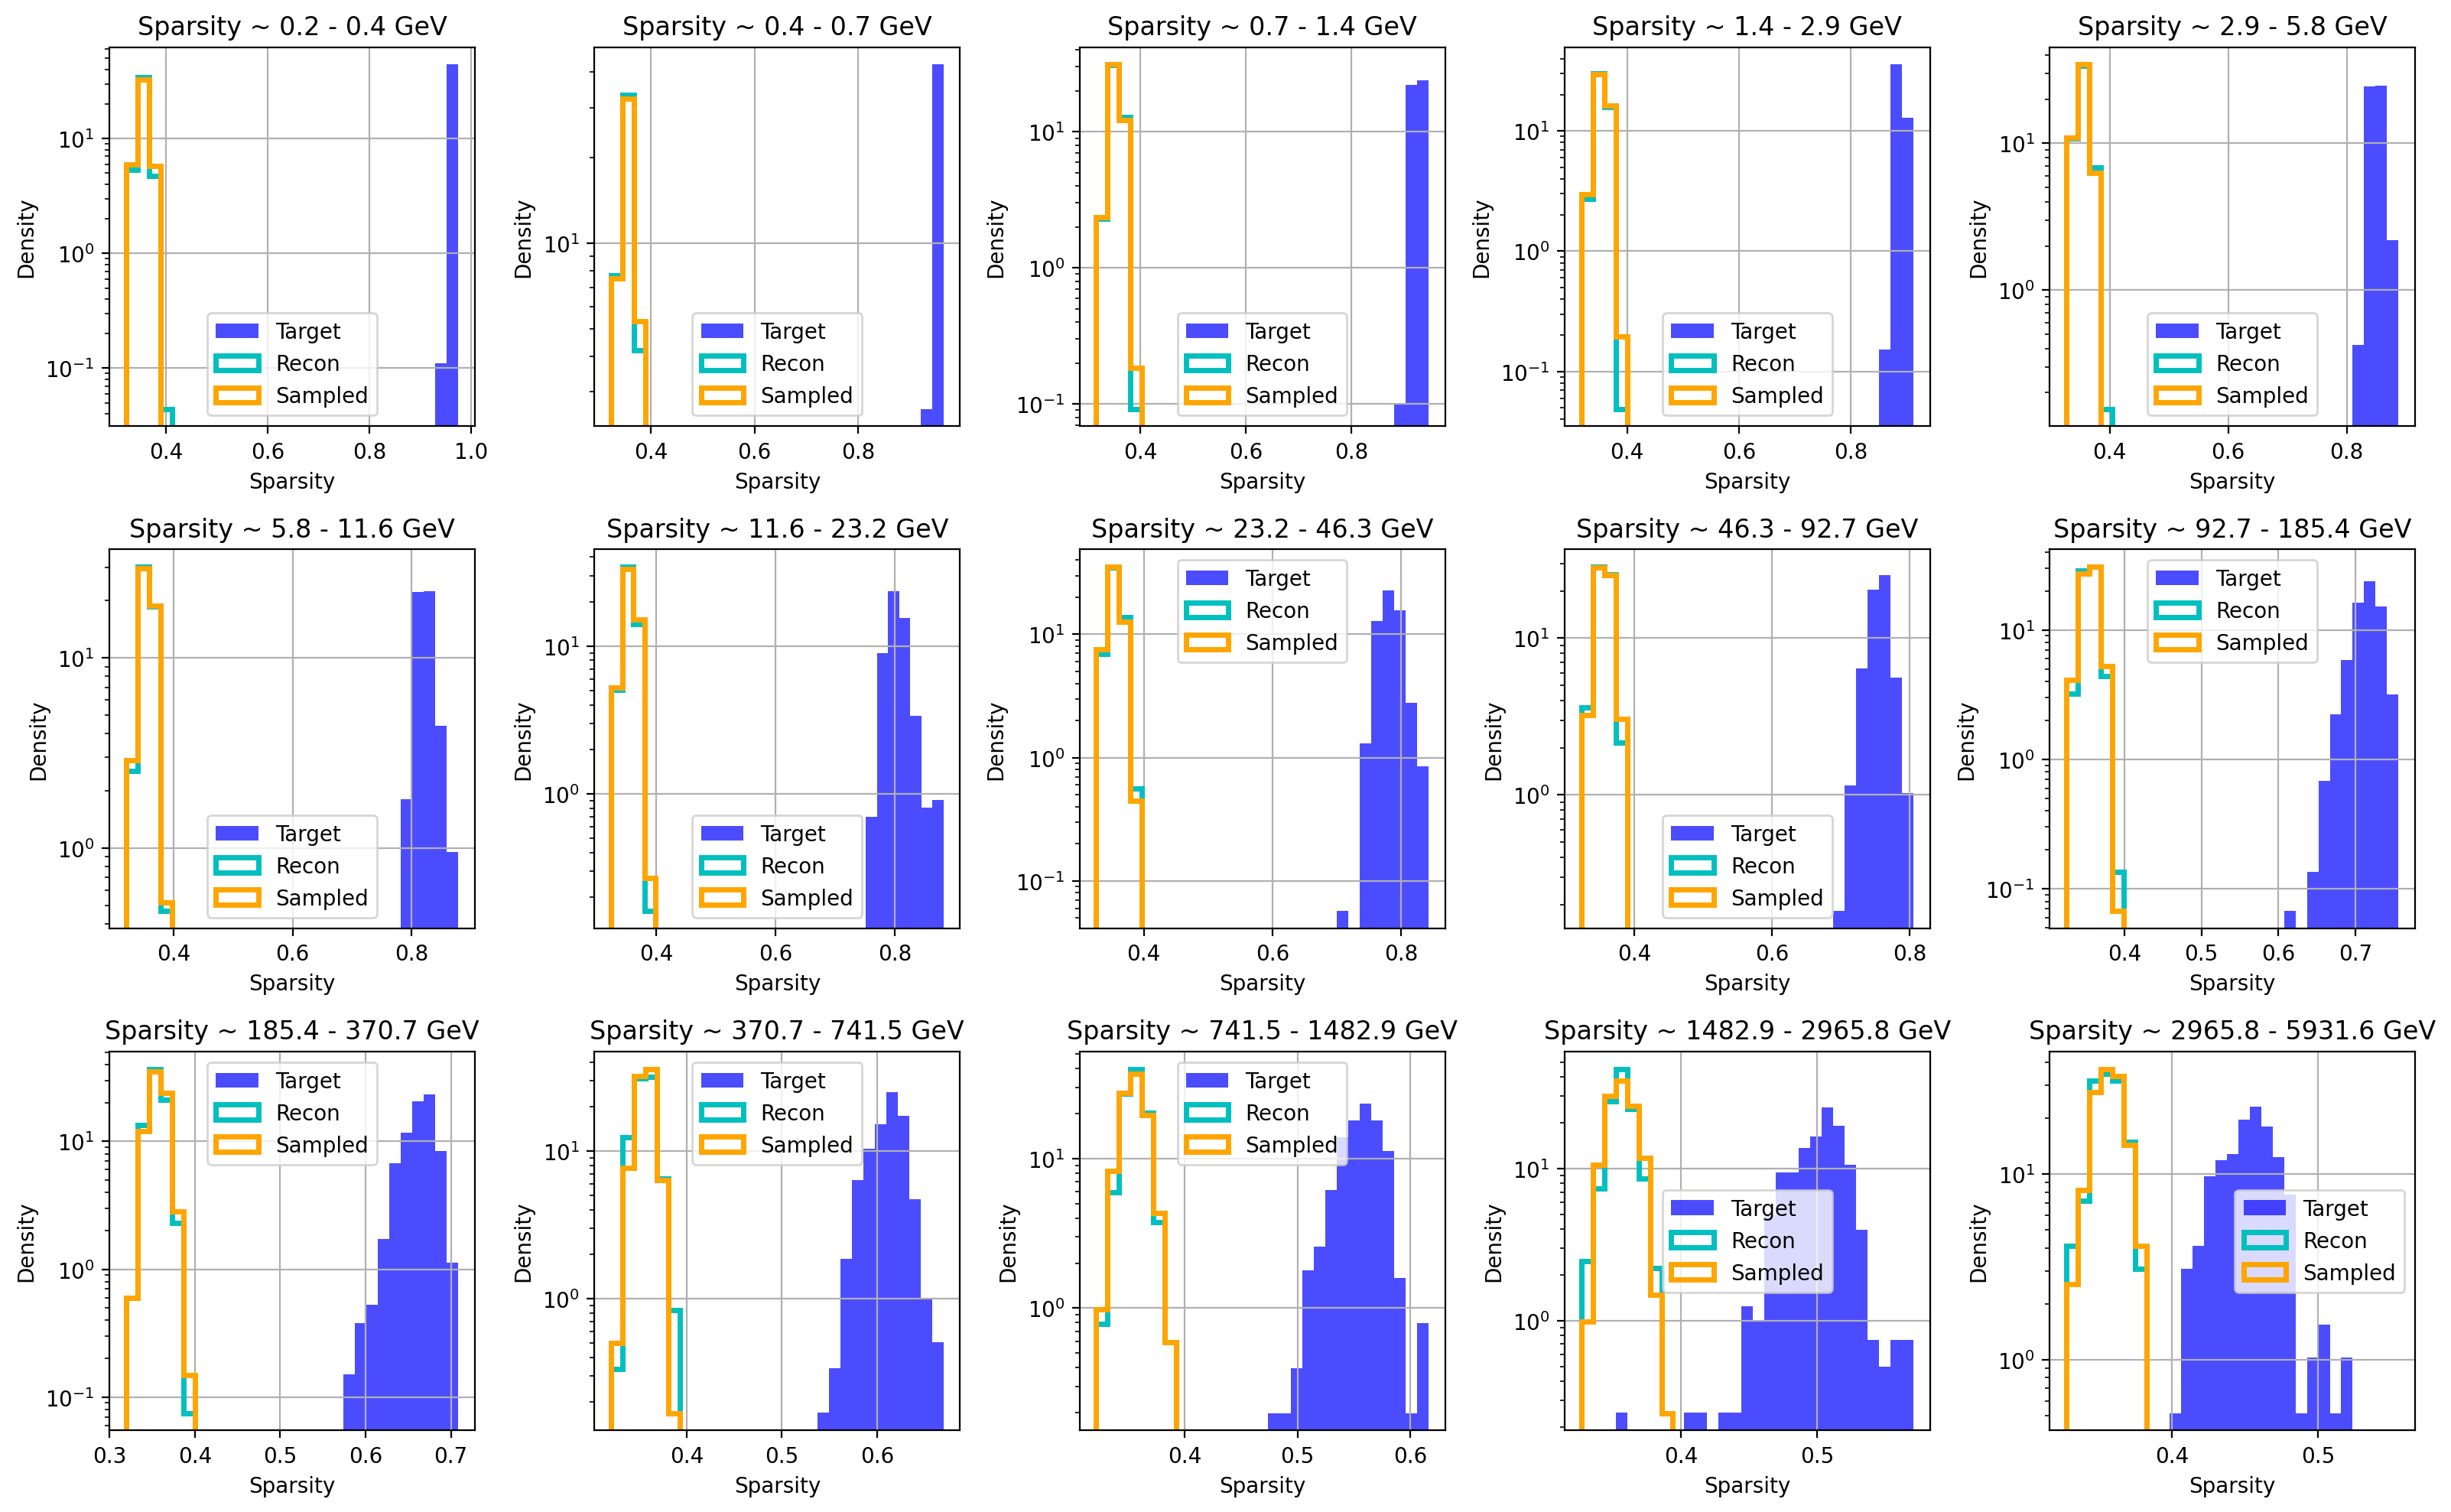

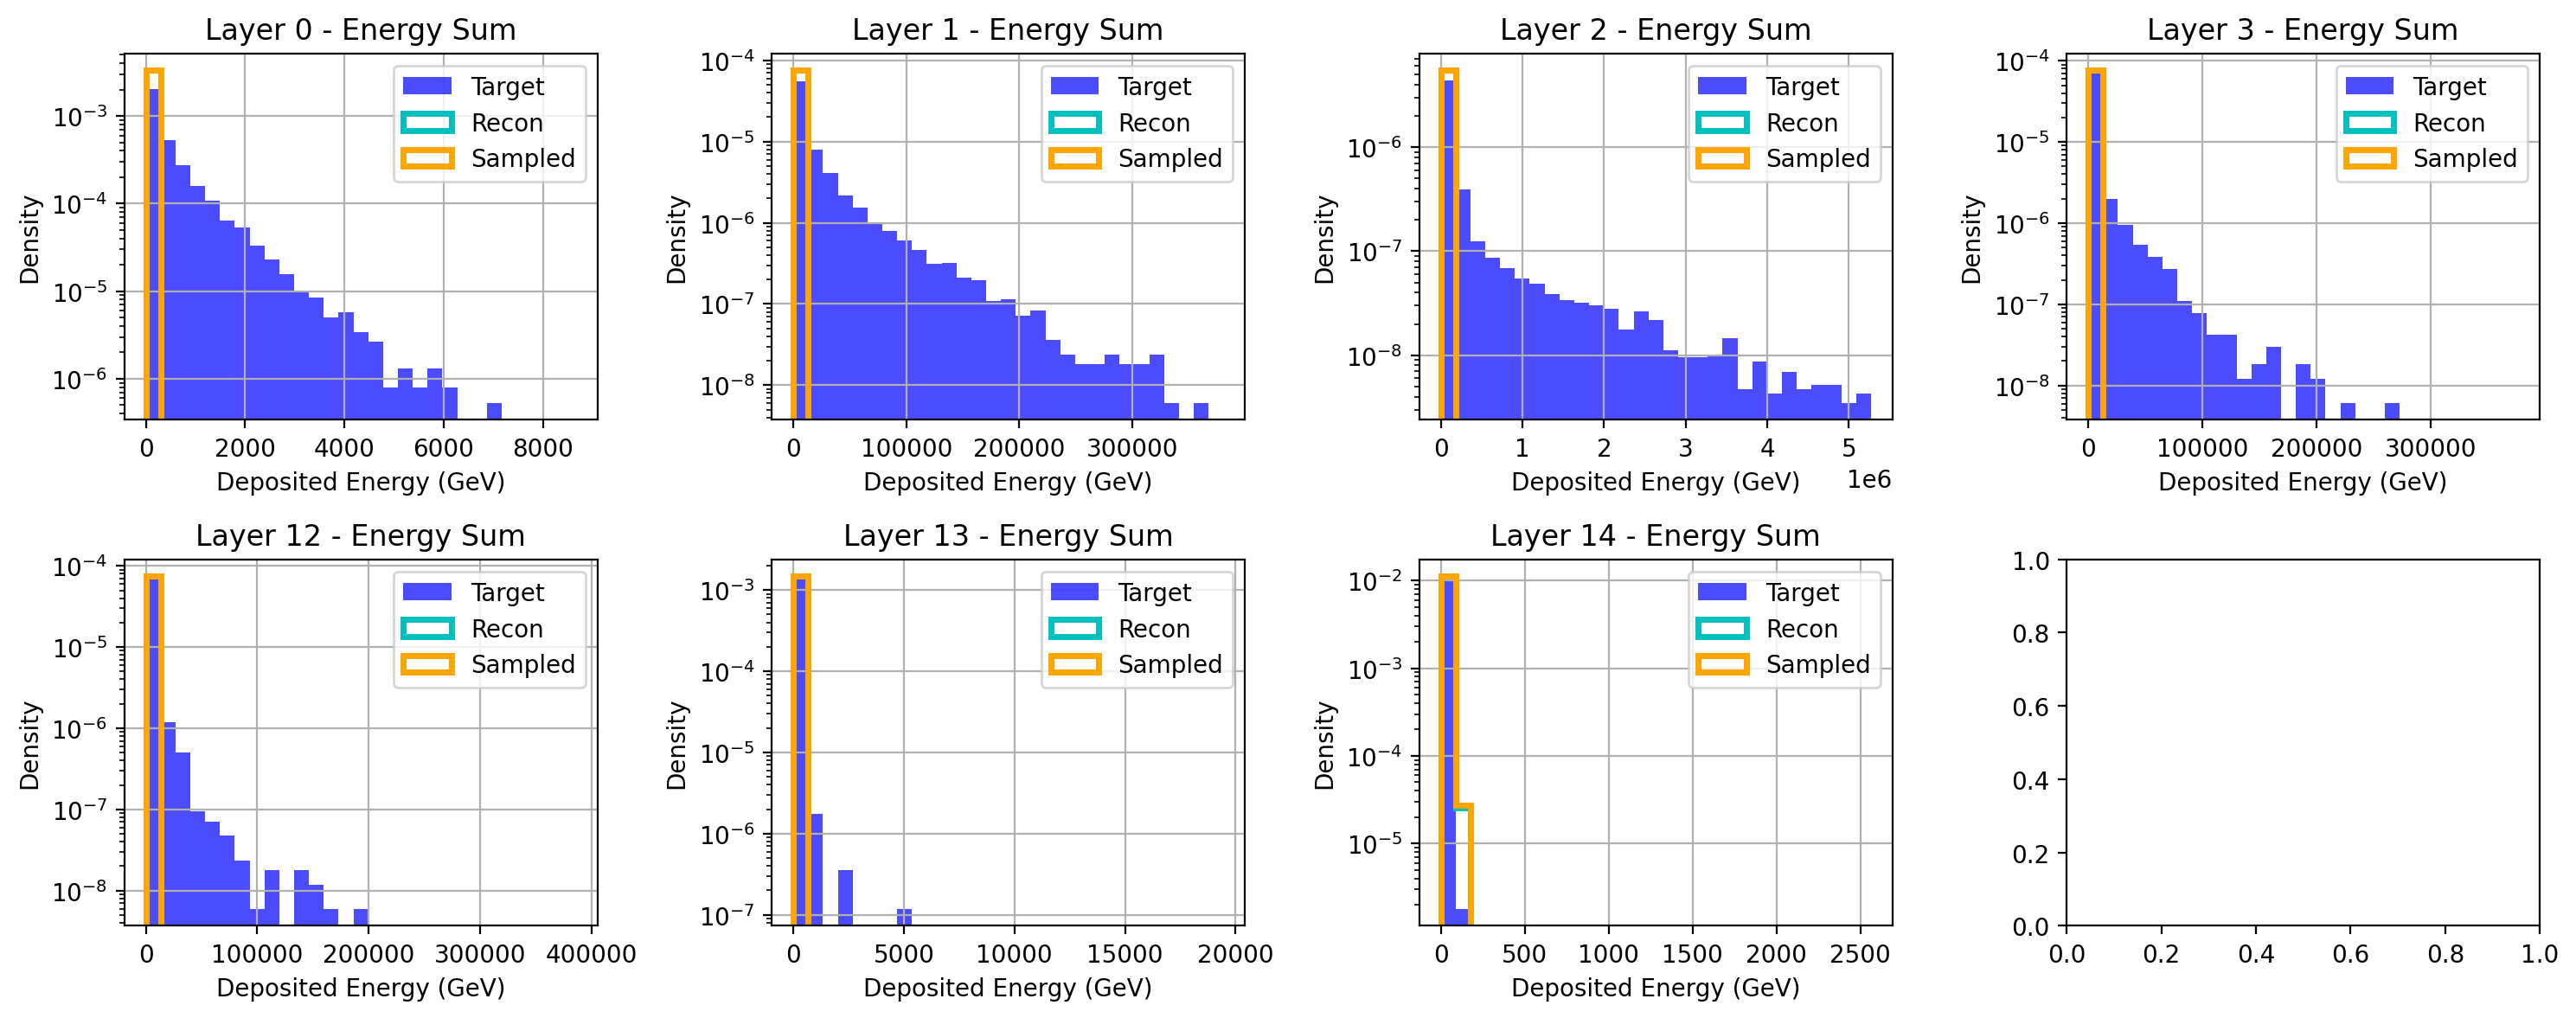

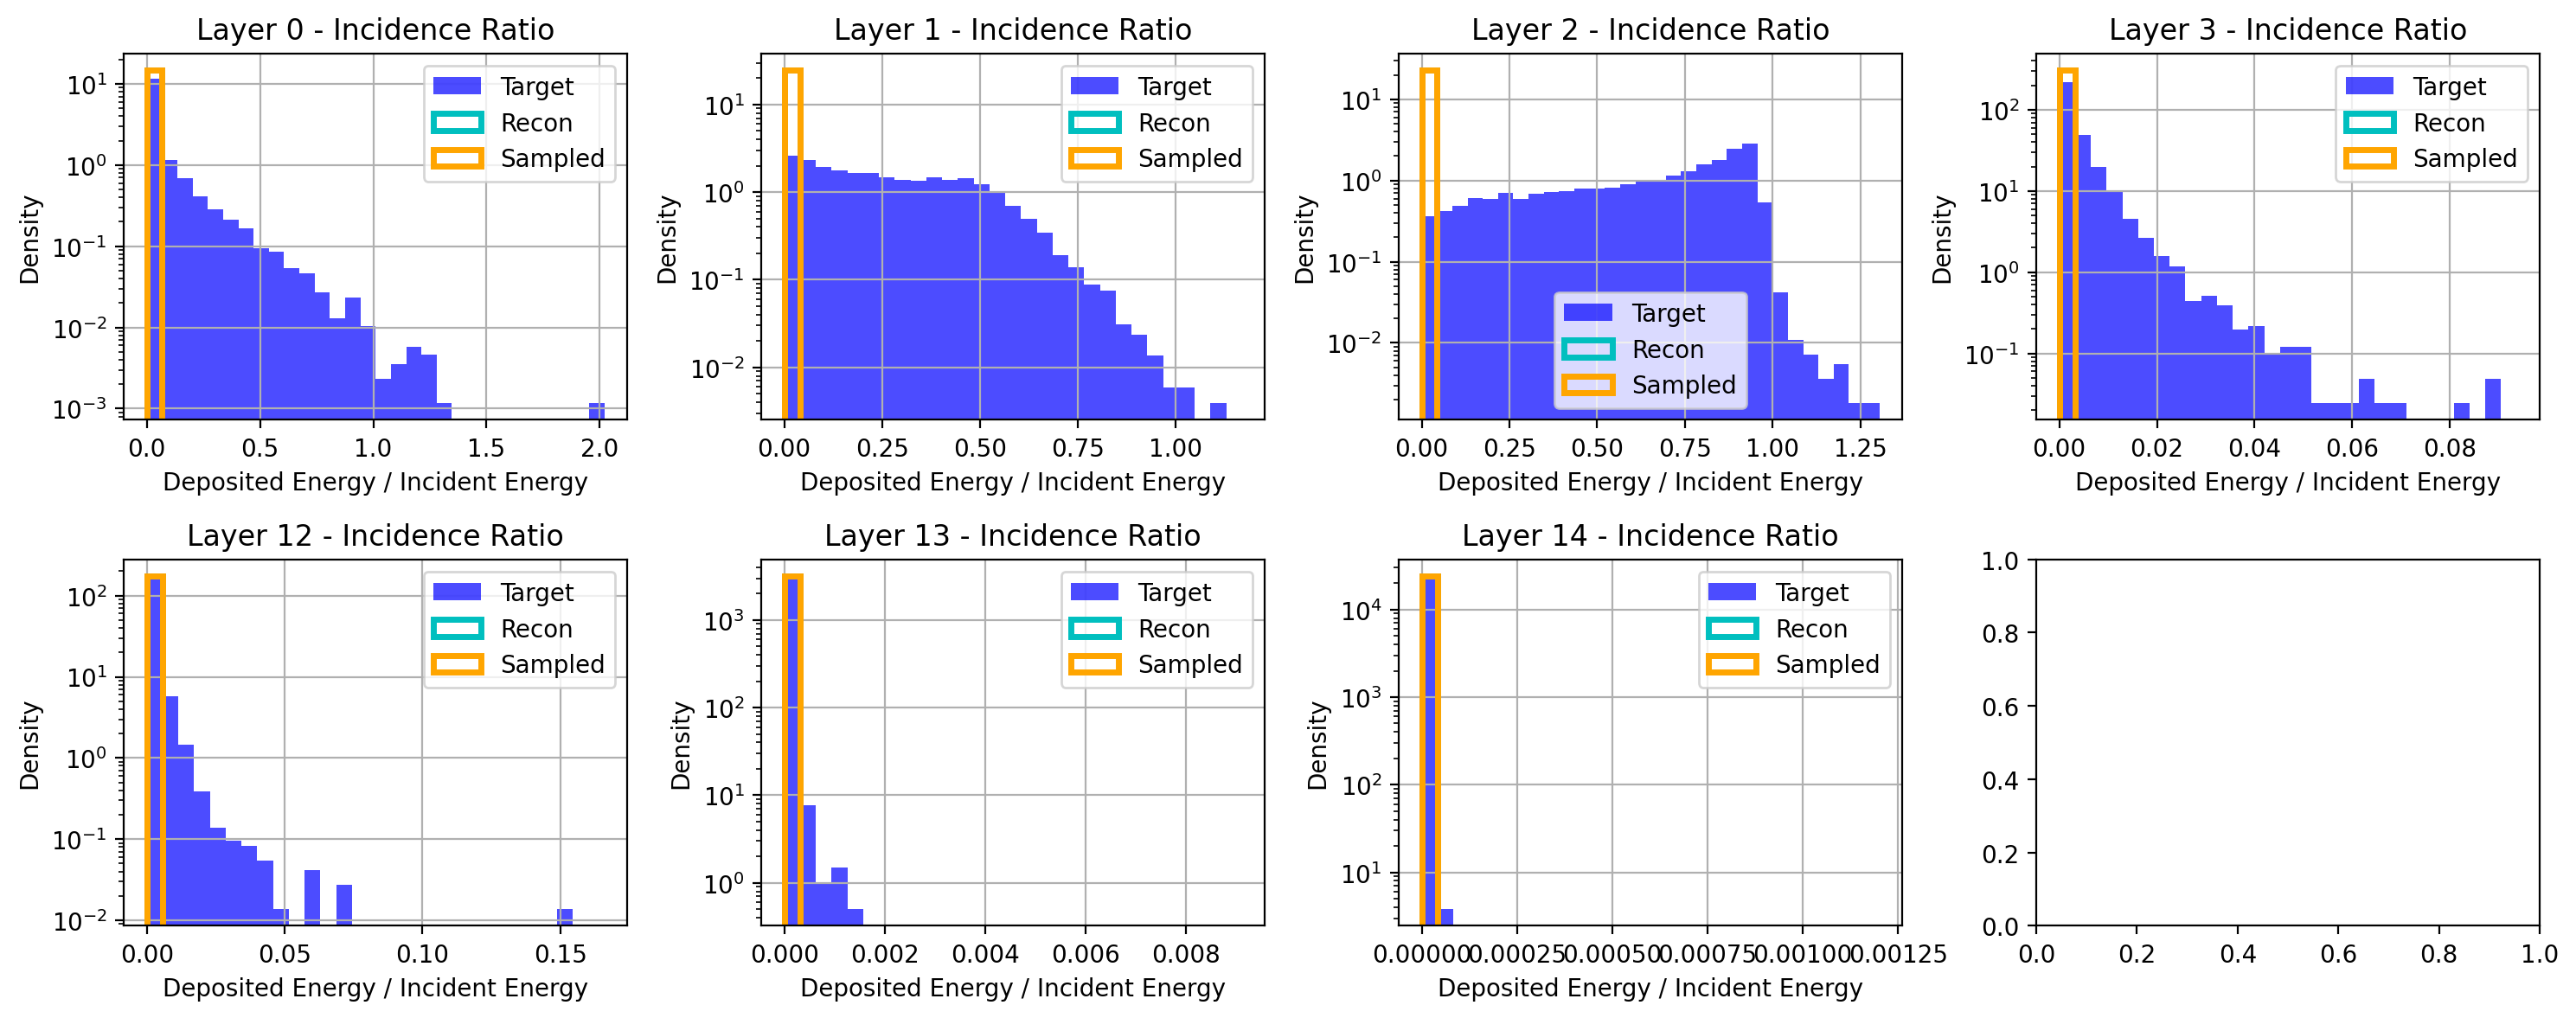

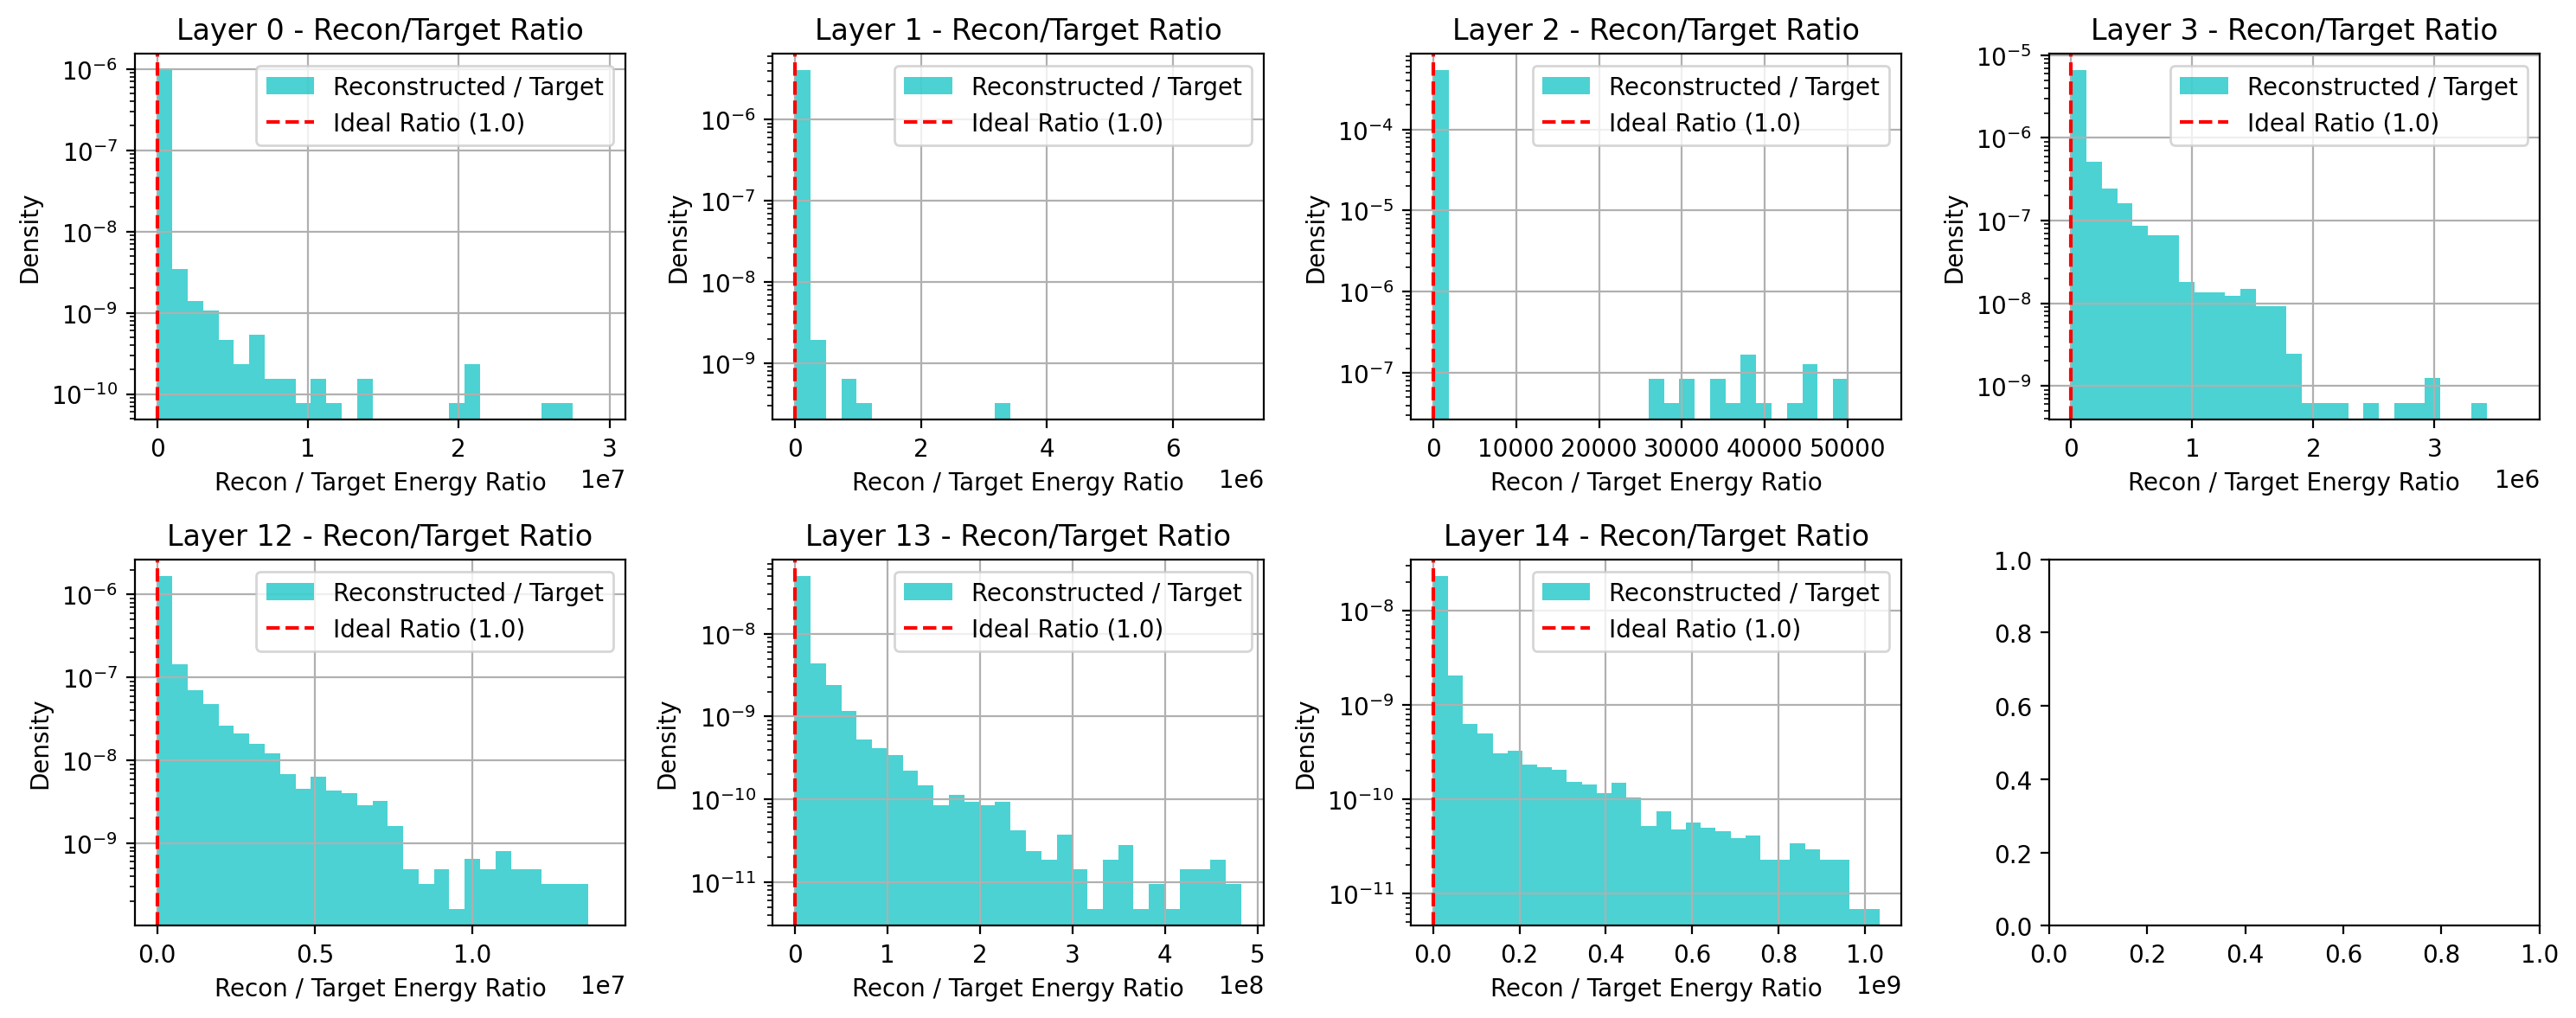

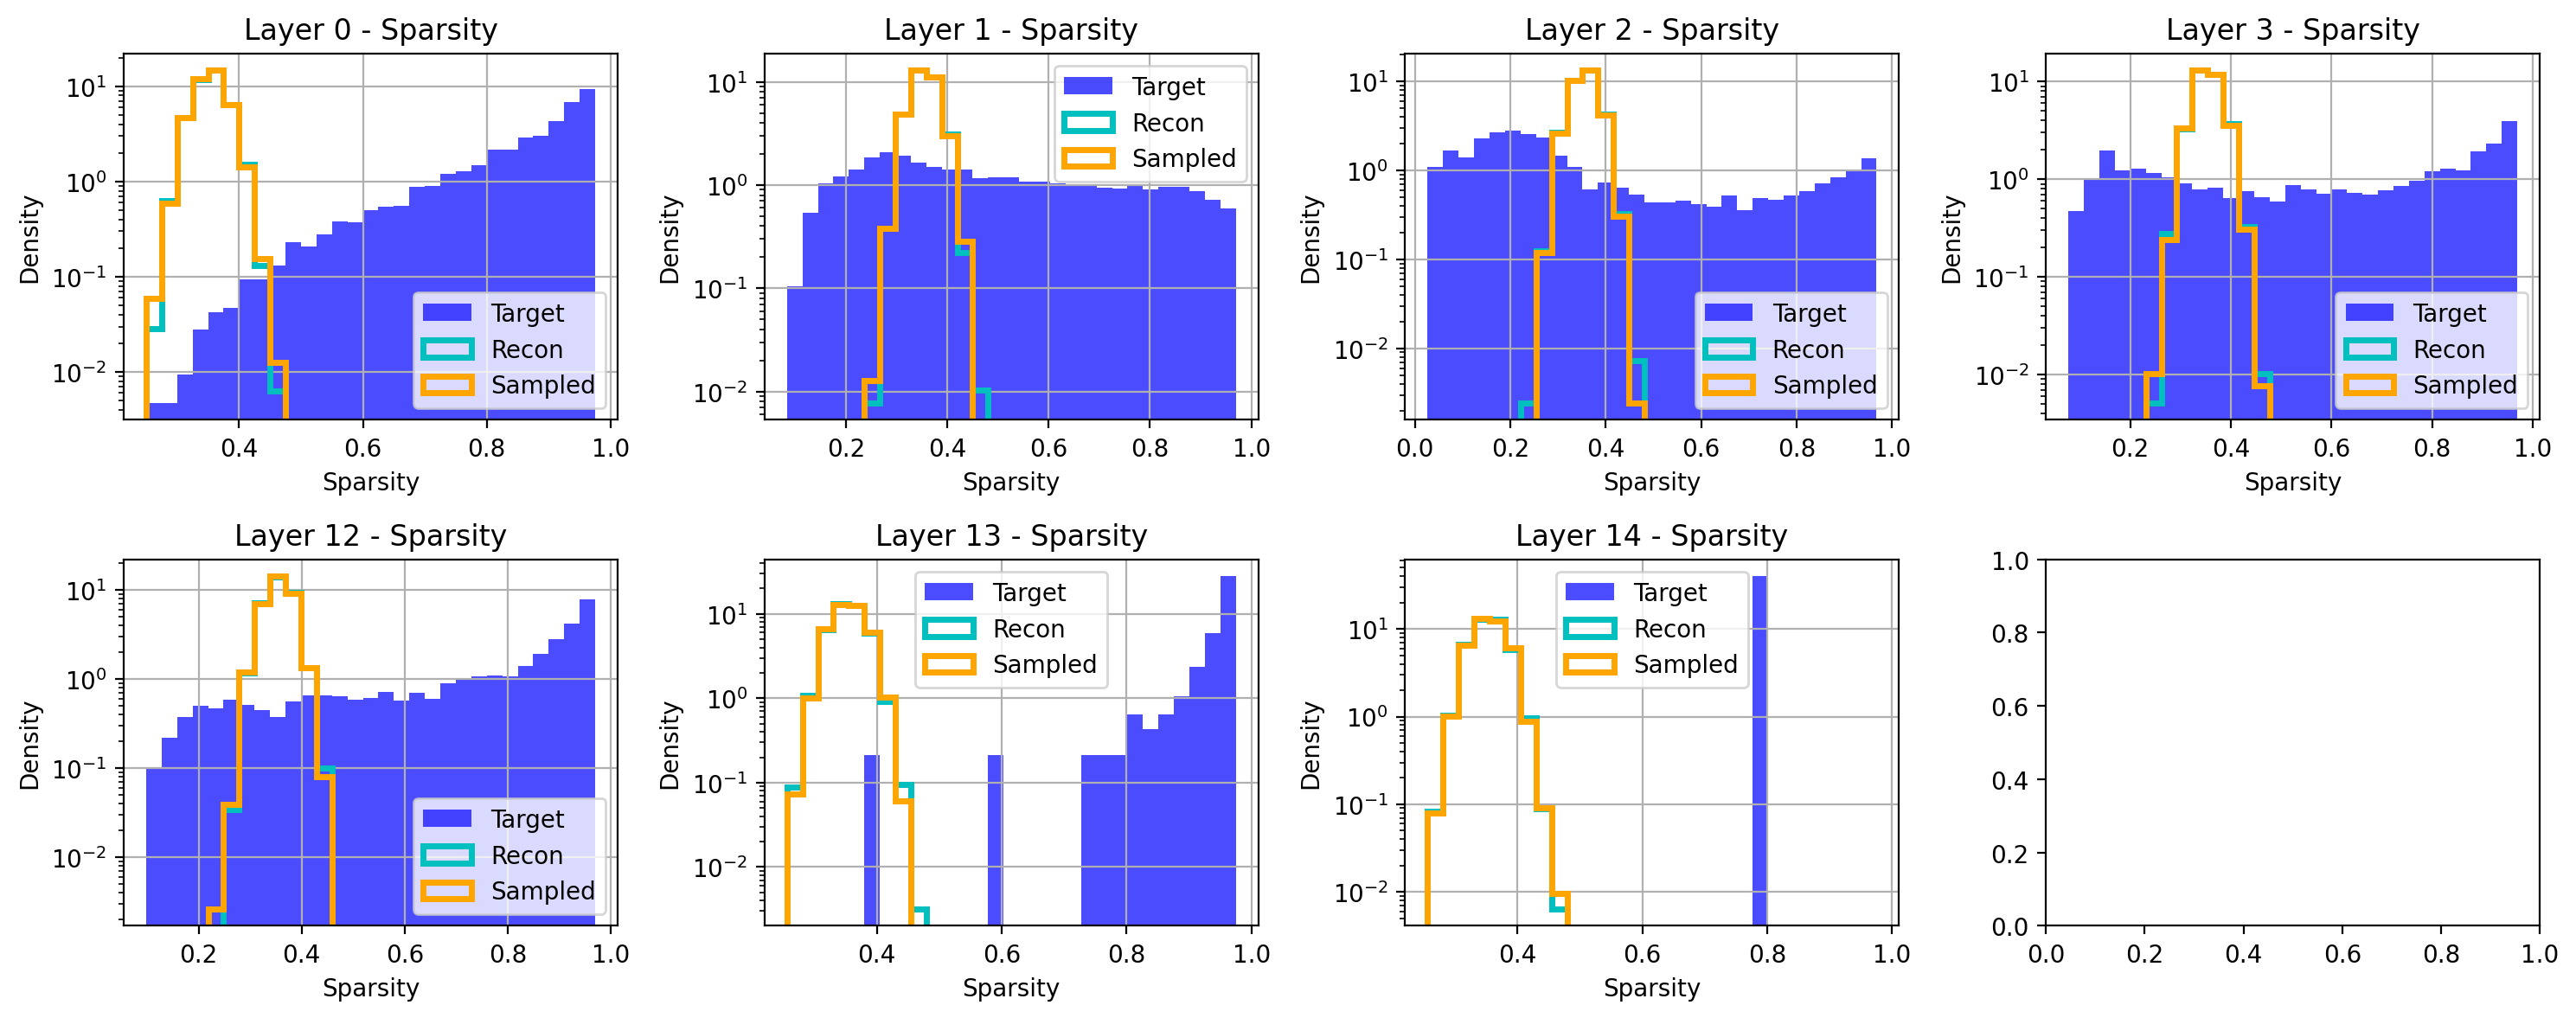

In [15]:
import importlib
import utils.plots
importlib.reload(utils.plots)
from utils.plots import vae_plots
vae_plots(
    cfg = self._config,
    incident_energies = self.incident_energy,
    target_showers = self.showers,
    recon_showers = self.showers_recon,
    sampled_showers = self.showers_prior
)

In [ ]:
engine.evaluate(engine.data_mgr.val_loader, 0)

In [ ]:
x = next(iter(engine.data_mgr.train_loader))
# next(iter(dataMgr.train_loader))

In [ ]:
with torch.no_grad():
    enc_data = engine.model.encoder(x[0].to(dev, dtype=torch.float32), x[1].to(dev, dtype=torch.float32))

In [ ]:
len(enc_data)
len(enc_data[1])

In [ ]:
with torch.no_grad():
    enc_data = engine.model((x[0].to(dev, dtype=torch.float32), x[1].to(dev, dtype=torch.float32)))

In [ ]:
with torch.no_grad():
    l = engine.model.loss(x[0].to(dev, dtype=torch.float32), enc_data)

In [ ]:
l

In [ ]:
post_samples = enc_data[2]
# post_samples = [torch.rand(128,302, device=dev) * 10 for _ in range(4)]
post_samples[0]

In [ ]:
engine.model.prior.energy_exp(
    post_samples[0].to(dtype=torch.float),
    post_samples[1],
    post_samples[2],
    post_samples[3]
)

In [ ]:
(- (post_samples[0].to(dtype=torch.float) @ engine.model.prior.weight_dict["01"] @ post_samples[1].T).diagonal() - \
(post_samples[0].to(dtype=torch.float) @ engine.model.prior.weight_dict["02"] @ post_samples[2].T.to(dtype=torch.float)).diagonal() - \
(post_samples[0].to(dtype=torch.float) @ engine.model.prior.weight_dict["03"] @ post_samples[3].T.to(dtype=torch.float)).diagonal() - \
(post_samples[1].to(dtype=torch.float) @ engine.model.prior.weight_dict["12"] @ post_samples[2].T.to(dtype=torch.float)).diagonal() - \
(post_samples[1].to(dtype=torch.float) @ engine.model.prior.weight_dict["13"] @ post_samples[3].T.to(dtype=torch.float)).diagonal() - \
(post_samples[2].to(dtype=torch.float) @ engine.model.prior.weight_dict["23"] @ post_samples[3].T.to(dtype=torch.float)).diagonal() \
    - post_samples[1] @ engine.model.prior.bias_dict["1"] - \
post_samples[2] @ engine.model.prior.bias_dict["2"] - \
post_samples[3] @ engine.model.prior.bias_dict["3"]).mean()

In [ ]:
(- post_samples[1] @ engine.model.prior.bias_dict["1"].to(dtype=torch.float) - \
post_samples[2] @ engine.model.prior.bias_dict["2"].to(dtype=torch.float) - \
post_samples[3] @ engine.model.prior.bias_dict["3"].to(dtype=torch.float)).mean()

In [ ]:
post_samples[0].to(dtype=torch.float) @ engine.model.prior.bias_dict["0"]

In [ ]:
(engine.model.prior.weight_dict['01'] + torch.zeros((128,) +
                                                    (302,302),
                                                    device=engine.model.prior.weight_dict['01'].device)).shape


In [ ]:
# torch.zeros((128,) + 302,device=engine.model.prior.weight_dict[key].device)
post_samples[0].size(0)


In [ ]:
from model.rbm.zephyr import ZephyrRBM, ZephyrRBM_Old

In [ ]:
config.rbm.latent_nodes_per_p=512
config.rbm.optimize_partition = True
new = ZephyrRBM(config)
old = ZephyrRBM_Old(config)

binwidth = 1.0
new_data, old_data = {}, {}
for key in new.weight_dict.keys():
    # data[key] = engine.model.prior.weight_dict[key].sign().abs().sum(dim=0).detach().cpu().numpy()
    new_data[key] = new._weight_mask_dict[key].abs().sum(dim=0).cpu().numpy()
for key in old.weight_dict.keys():
    old_data[key] = old._weight_mask_dict[key].abs().sum(dim=0).cpu().numpy()
    


In [ ]:
def plot_weights(data, label):
    # Create 2x2 grid of subplots
    fig, axs = plt.subplots(2, 3, figsize=(10, 7), sharey=True, sharex=True, tight_layout=True)  # 2x2 grid, figure size 10x10
    fig.text(0.5, 0.0, 'Couplings/qubit', ha='center', fontsize=15)
    fig.text(0.0, 0.4, 'Histogram', rotation=90, ha='center', fontsize=15)

    # Plot data on each subplot
    labels, counts = np.unique(data['01'], return_counts=True)
    axs[0,0].bar(labels, counts, align='center', color="b", alpha=0.8)
    # axs[0, 0].hist(data['01'], bins=np.arange(min(data['01']), max(data['01']) + binwidth, binwidth), histtype='stepfilled', linewidth=2.5, color="b", alpha=0.7, align='center')
    axs[0,0].grid("True")
    axs[0,0].legend(["v to h"], fontsize=18)

    labels, counts = np.unique(data['02'], return_counts=True)
    axs[0,1].bar(labels, counts, align='center', color="b", alpha=0.9)
    axs[0,1].grid("True")
    axs[0,1].legend(["v to s"], fontsize=18)

    labels, counts = np.unique(data['03'], return_counts=True)
    axs[0,2].bar(labels, counts, align='center', color="b", alpha=0.9)
    axs[0,2].grid("True")
    axs[0,2].legend(["v to t"], fontsize=18)

    labels, counts = np.unique(data['12'], return_counts=True)
    axs[1,0].bar(labels, counts, align='center', color="b", alpha=0.9)
    axs[1,0].grid("True")
    axs[1,0].legend(["h to s"], fontsize=18)

    labels, counts = np.unique(data['13'], return_counts=True)
    axs[1,1].bar(labels, counts, align='center', color="b", alpha=0.9)
    axs[1,1].grid("True")
    axs[1,1].legend(["h to t"], fontsize=18)

    labels, counts = np.unique(data['23'], return_counts=True)
    axs[1,2].bar(labels, counts, align='center', color="b", alpha=0.9)
    axs[1,2].grid("True")
    axs[1,2].legend(["s to t"], fontsize=18)

    # plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/weights_plot_zephyr.png', bbox_inches="tight")
    plt.suptitle(f"Weight mask histogram for {label}", fontsize=20)

    plt.show()
plot_weights(new_data, "new algorithm")
plot_weights(old_data, "old algorithm")

In [ ]:
zph = new
# plt.hist(torch.cat((zph._weight_mask_dict['01'],zph._weight_mask_dict['02'],zph._weight_mask_dict['03']),1).sum(dim=1).numpy(), bins=20)
# plt.show()
# plt.hist(torch.cat((zph._weight_mask_dict['01'].transpose(1,0),zph._weight_mask_dict['12'],zph._weight_mask_dict['13']),1).sum(dim=1), bins=20)
# plt.show()
# plt.hist(torch.cat((zph._weight_mask_dict['02'].transpose(1,0),zph._weight_mask_dict['12'].transpose(1,0),zph._weight_mask_dict['23']),1).sum(dim=1), bins=20)
# plt.show()
# plt.hist(torch.cat((zph._weight_mask_dict['03'].transpose(1,0),zph._weight_mask_dict['13'].transpose(1,0),zph._weight_mask_dict['23'].transpose(1,0)),1).sum(dim=1), bins=20)
# plt.show()
def plot_total_weights(zeph, label):
    fig, ax = plt.subplots(2, 2, figsize=(10, 7), sharey=True, sharex=True, tight_layout=True)  # 2x2 grid, figure size 10x10
    fig.text(0.5, 0.0, 'Couplings/qubit', ha='center', fontsize=15)
    fig.text(0.0, 0.4, 'Histogram', rotation=90, ha='center', fontsize=15)
    ax[0, 0].hist(torch.cat((zeph._weight_mask_dict['01'], zeph._weight_mask_dict['02'], zeph._weight_mask_dict['03']), 1).sum(dim=1).numpy(), bins=20)
    ax[0, 0].set_title("v to h, s, t")
    ax[0, 1].hist(torch.cat((zeph._weight_mask_dict['01'].transpose(1,0), zeph._weight_mask_dict['12'], zeph._weight_mask_dict['13']), 1).sum(dim=1), bins=20)
    ax[0, 1].set_title("h to v, s, t")
    ax[1, 0].hist(torch.cat((zeph._weight_mask_dict['02'].transpose(1,0), zeph._weight_mask_dict['12'].transpose(1,0), zeph._weight_mask_dict['23']), 1).sum(dim=1), bins=20)
    ax[1, 0].set_title("s to v, h, t")
    ax[1, 1].hist(torch.cat((zeph._weight_mask_dict['03'].transpose(1,0), zeph._weight_mask_dict['13'].transpose(1,0), zeph._weight_mask_dict['23'].transpose(1,0)), 1).sum(dim=1), bins=20)
    ax[1, 1].set_title("t to v, h, s")
    fig.suptitle(f"Total weight mask histogram for {label}", fontsize=20)

plot_total_weights(new, "new algorithm")
plot_total_weights(old, "old algorithm")

In [ ]:
def plot_weights_overlay(new_data, old_data):
    fig, axs = plt.subplots(2, 3, figsize=(10, 7), sharey=True, sharex=True, tight_layout=True)
    fig.text(0.5, 0.0, 'Couplings/qubit', ha='center', fontsize=15)
    fig.text(0.0, 0.4, 'Histogram', rotation=90, ha='center', fontsize=15)

    keys = ['01', '02', '03', '12', '13', '23']
    titles = ["v to h", "v to s", "v to t", "h to s", "h to t", "s to t"]
    
    for i, key in enumerate(keys):
        ax = axs[i // 3, i % 3]
        data_new = new_data[key]
        data_old = old_data[key]
        # Determine bin edges to align histograms, centering on integers
        min_val = min(data_new.min(), data_old.min())
        max_val = max(data_new.max(), data_old.max())
        bins = np.arange(min_val, max_val + 2) - 0.5  # Shift by 0.5 to center bins on integers
        ax.hist(data_new, bins=bins, alpha=0.5, label='new', color='blue')
        ax.hist(data_old, bins=bins, alpha=0.5, label='old', color='red')
        ax.legend()
        ax.set_title(titles[i])
        ax.grid(True)

    plt.suptitle("Weight mask histogram comparison", fontsize=20)
    plt.show()
plot_weights_overlay(new_data, old_data)

In [ ]:
def compute_total_connections(zeph):
    total_v = torch.cat((zeph._weight_mask_dict['01'], zeph._weight_mask_dict['02'], zeph._weight_mask_dict['03']), 1).sum(dim=1).cpu().numpy()
    total_h = torch.cat((zeph._weight_mask_dict['01'].transpose(1,0), zeph._weight_mask_dict['12'], zeph._weight_mask_dict['13']), 1).sum(dim=1).cpu().numpy()
    total_s = torch.cat((zeph._weight_mask_dict['02'].transpose(1,0), zeph._weight_mask_dict['12'].transpose(1,0), zeph._weight_mask_dict['23']), 1).sum(dim=1).cpu().numpy()
    total_t = torch.cat((zeph._weight_mask_dict['03'].transpose(1,0), zeph._weight_mask_dict['13'].transpose(1,0), zeph._weight_mask_dict['23'].transpose(1,0)), 1).sum(dim=1).cpu().numpy()
    return total_v, total_h, total_s, total_t

def plot_total_weights_overlay(new, old):
    fig, axs = plt.subplots(2, 2, figsize=(10, 7), sharey=True, sharex=True, tight_layout=True)
    fig.text(0.5, 0.0, 'Couplings/qubit', ha='center', fontsize=15)
    fig.text(0.0, 0.4, 'Histogram', rotation=90, ha='center', fontsize=15)

    total_new = compute_total_connections(new)
    total_old = compute_total_connections(old)

    all_data = np.concatenate((total_new[0], total_new[1], total_new[2], total_new[3],
                               total_old[0], total_old[1], total_old[2], total_old[3]))
    min_val = int(all_data.min())
    max_val = int(all_data.max())
    bins = np.arange(min_val, max_val + 1, 1)  #

    titles = ["v to h, s, t", "h to v, s, t", "s to v, h, t", "t to v, h, s"]
    
    for i in range(len(titles)):
        ax = axs[i // 2, i % 2]
        data_new = total_new[i]
        data_old = total_old[i]
        ax.hist(data_new, bins=bins, alpha=0.5, label='new', color='blue', align='mid')
        ax.hist(data_old, bins=bins, alpha=0.5, label='old', color='red', align='mid')
        ax.set_xticks(bins)  # Integer ticks
        ax.legend()
        ax.set_title(titles[i])
        ax.grid(True)

    plt.suptitle("Total weight mask histogram comparison", fontsize=20)
    plt.show()


plot_total_weights_overlay(new, old)